In [50]:
%pylab inline
from datetime import date
from datetime import datetime
import os
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import (mean_squared_error, r2_score)
from sklearn.model_selection import GridSearchCV
from scipy.stats import ks_2samp

Populating the interactive namespace from numpy and matplotlib


/home/juanchosol1996/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'e', 'datetime', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [51]:
n1 = np.array([(10,3),(50,1),(80,1)])
n2 = np.array([(80,15),(90,13),(100,10)])
arqs ={"adam": n1,
      "lbfgs":n2
}

n1_10 = np.array([(80,7),(90,5),(100,9)])
n2_10 = np.array([(50,9),(90,9),(100,10)])
arqs10 ={"adam": n1_10,
      "lbfgs":n2_10
}


In [ ]:
#Funciones para crear matrices de entrenaminto y pruebas

In [52]:
def train_X_Y(dias, deltas, d_inicial,num_samples,num_features):    ##d_inicial : 0 a 2508
    ##dias: vector de dia de la semana para cada dia (L=1...V=5)
    ##precios: vector de pecios para cada dia
    ##d_inicial: Primer dia del entrenamiento (0 a 2508) es num_features-1 dias antes que el primer Y de entrenamiento 
    ##num_samples: Número de muestras para entrenar 
    ##num_features: Número de parametros de entrenamiento (1+ número de dias con que se predice el precio)
    
    
    
    num_dias = num_features-1
   
    dias = dias[d_inicial+num_dias:d_inicial+num_dias+num_samples]
    dias = dias.reshape(len(dias),1)
    
    d=deltas[d_inicial:d_inicial+num_samples]
    
    for i in range(d_inicial+1,d_inicial+num_dias):
        m = deltas[i:i+num_samples]
        d =  np.column_stack((d,m))
            
    X = np.column_stack((d,dias))
             
    Y = deltas[d_inicial+num_dias:d_inicial+num_dias+num_samples]
    
    assert (X.shape == (num_samples, num_features))
    assert (Y.shape == (num_samples,))
    
    train = {"X": X,
                "Y": Y
            }
    
    return train



def test_X_Y(dias, deltas, d_inicial,num_samples,num_features):
    test = train_X_Y(dias, deltas, d_inicial,num_samples,num_features)
    
    return test

def cal_porcentaje(porcentajes):
    prcts=[]
    acum = porcentajes[0]
    prcts.append(acum)
    for i in range(1,len(porcentajes)):
        acum = acum*porcentajes[i]
        prcts.append(acum)
    
    prcts = np.array(prcts)
    return prcts

def errores(Y_expected,Y_predict):
    error_RMS= sqrt(mean_squared_error(Y_expected,Y_predict))
    error_MBE= mean(Y_expected-Y_predict)
    p_value = ks_2samp(Y_expected,Y_predict)[1]
    r2 = r2_score(Y_expected,Y_predict)
    
    error_RMS= np.round(error_RMS,3)
    error_MBE= np.round(error_MBE,4)
    p_value = np.round(p_value,2)
    r2 = np.round(r2,2)
                    
                    
    error = {"RMS": error_RMS,
             "MBE": error_MBE,
             "P-Value": p_value,
             "R2":r2
            }
    return error


def RMS(Y_prdct,Y):
    error = np.sqrt(sum((Y_prdct-Y)**2))/len(Y)
    return error

def graph_comb(values):
    k= np.array(values)
    sw = True

    while sw == True:
        sw = False
        for i in range(len(k)-1):
            temp1 = list(k[i])
            temp2 = list(k[i+1])
            if temp2[0]<temp1[0]:
                k[i]=temp2
                k[i+1]=temp1
                sw=True

            if temp2[0]==temp1[0]:
                if temp2[1]<temp1[1]:
                    k[i]=temp2
                    k[i+1]=temp1
                    sw=True
    a=[]
    b=[]
    i=0
    while i in range (len(k)):
        d = k[i]
        a.append(d)
        cnt=1
        l = k[i+1:]
        for j in range(len(l)):
            if sum(l[j]==d)==2:
                cnt= cnt+1
            else:
                j= len(l)
        b.append(cnt)
        i= i+cnt
    
    plt.bar(range(len(a)),b)
    plt.plot()
    plt.subplots_adjust(left=0.5, bottom=1, right=3, top=2)
    plt.show()
    print(a)
    print(b)

In [ ]:
## Poblando datos

In [53]:
datos_csv = os.path.join( '.','COLCAP.csv')
datos_pd = pd.read_csv(datos_csv, sep = ',',
                encoding='latin-1', parse_dates =[0], infer_datetime_format= True)

In [54]:
a=datos_pd["Fecha (dd/mm/aaaa)"]

dias = []

for i in range(len(a)):
    d = a[i].weekday() + 1
    dias.append(d)
    
d = np.array(dias)

In [55]:
c = datos_pd["Valor COLCAP"]
c = np.array(c)
for i in range(len(c)):
    c[i] = c[i].replace(',',"")


price=np.array(c, dtype= np.float64)

In [56]:
b = datos_pd["Variación porcentual"]
b = np.array(b)
for i in range(len(b)):
    b[i] = b[i].replace('%',"")


p=np.array(b, dtype= np.float64)

In [57]:
len(price)

2509

In [ ]:
## Prueba

In [99]:
## Definición de matrices de entreno
train=train_X_Y(d,p,1202,1000,11)

In [100]:
#Definición de matrices de prueba
test=test_X_Y(d,p,2509-30-10,30,11)

In [149]:
#Entreno del sistema adam
e = 10
rg = None
for l in range(20):
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always") 
        r = MLPRegressor(hidden_layer_sizes=arqs10["adam"][2], max_iter= 200, activation="relu",shuffle= False, solver= "adam", tol=0.000001 )
        r.fit(train["X"],train["Y"])
    
    if w==[]:
        error = errores(train['Y'], r.predict(train['X']))['RMS']
    else:
        error= e
    
    if error<e:
        e=error
        rg=r
        print(e)
        

3.179
3.087
3.014
3.003


In [150]:
print(rg.n_iter_)
print(e)
print(rg.solver)
print(rg.hidden_layer_sizes)

189
3.003
adam
[100   9]


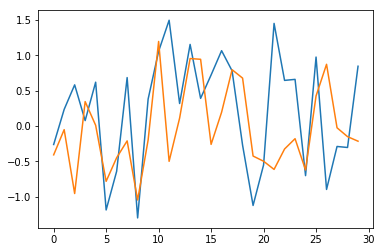

El Error RMS del entreno es: 3.003
El Error MBE del entreno es: 0.0691
El P-Value del entreno es: 0.0

El Error RMS de la prueba es: 0.862
El Error MBE de la prueba es: 0.266
El P-Value de la prueba es: 0.05


In [151]:
#Grafica de predicción y real
y1 = np.array(test["Y"])
y2= np.array(rg.predict(test["X"]))
plt.plot(y1)
plt.plot(y2)
error_train = errores(train['Y'],rg.predict(train['X']))
error_test = errores(test['Y'],rg.predict(test['X']))

plt.show()

print("El Error RMS del entreno es: " + str(error_train['RMS']))
print("El Error MBE del entreno es: " + str(error_train['MBE']))
print("El P-Value del entreno es: " + str(error_train['P-Value']))
print('')
print("El Error RMS de la prueba es: " + str(error_test['RMS']))
print("El Error MBE de la prueba es: " + str(error_test['MBE']))
print("El P-Value de la prueba es: " + str(error_test['P-Value']))

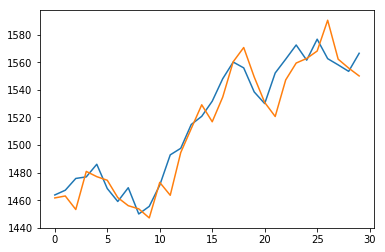

El Error RMS de la prueba es: 13.088
El Error MBE de la prueba es: 3.9419
El P-Value de la prueba es: 0.76
El R^2 de la prueba es: 0.9


In [152]:
y_1=price[2509-30:2509]
preprice =price[2509-1-30:2509-1]
plt.plot(y_1[-30:])
prct = rg.predict(test["X"])/100+1
#prct = test["Y"]/100+1
#prct = cal_porcentaje(prct)

y_2 = preprice*prct
plt.plot(y_2)
plt.show()

error = errores(y_1,y_2)
print("El Error RMS de la prueba es: " + str(error['RMS']))
print("El Error MBE de la prueba es: " + str(error['MBE']))
print("El P-Value de la prueba es: " + str(error['P-Value']))
print("El R^2 de la prueba es: " + str(error['R2']))

In [ ]:
#Entreno del sistema lbfgs
e = 10
rg = None
for l in range(10):
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always") 
        r = MLPRegressor(hidden_layer_sizes=(100,15), max_iter= 200, activation="relu",shuffle= False, solver= "lbfgs", warm_start=False, learning_rate_init= 0.000001)
        r.fit(train["X"],train["Y"])
        
        
    if w==[]:
        error = errores(train['Y'], r.predict(train['X']))['RMS']
    else:
        error= e

    if error<e:
        e=error
        rg=r
        print(e)
        

In [ ]:
print(rg.n_iter_)
print(e)

In [ ]:
#Grafica de predicción y real
y1 = np.array(test["Y"])
y2= np.array(rg.predict(test["X"]))
plt.plot(y1)
plt.plot(y2)
error_train = errores(train['Y'],rg.predict(train['X']))
#error_test=0
error_test = errores(test['Y'],rg.predict(test['X']))

plt.show()

print("El Error RMS del entreno es: " + str(error_train['RMS']))
print("El Error MBE del entreno es: " + str(error_train['MBE']))
print("El P-Value del entreno es: " + str(error_train['P-Value']))
print('')
print("El Error RMS de la prueba es: " + str(error_test['RMS']))
print("El Error MBE de la prueba es: " + str(error_test['MBE']))
print("El P-Value de la prueba es: " + str(error_test['P-Value']))

In [ ]:
y_1=price[2509-30:2509]
preprice =price[2509-1-30:2509-1]
plt.plot(y_1[-30:])
prct = rg.predict(test["X"])/100+1
#prct = test["Y"]/100+1
#prct = cal_porcentaje(prct)

y_2 = preprice*prct
plt.plot(y_2)
plt.show()

error = errores(y_1,y_2)
print("El Error RMS de la prueba es: " + str(error['RMS']))
print("El Error MBE de la prueba es: " + str(error['MBE']))
print("El P-Value de la prueba es: " + str(error['P-Value']))

In [ ]:
y1

In [ ]:
#Prueba del modelo
rg.score(train["X"], train["Y"])

In [ ]:
rg.score(test["X"], test["Y"])

In [ ]:
c= []
a=[]
for i in range (10,110,10):
    for j in range (1,11):
        a.append((i,j))

parameters = {'hidden_layer_sizes':a}
r = MLPRegressor(solver='adam')
clf = GridSearchCV(r, parameters,scoring= 'neg_mean_squared_error', return_train_score= 'False')

for i in range(20):
    
    with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            clf.fit(train['X'], train['Y'])
    c.append(clf.best_params_['hidden_layer_sizes'])
    print('ok')
    
print(c)
    
n = c
graph_comb(n)

In [ ]:
import time
print("End")
time.sleep(120)
print("Begin")

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
[(70, 1), (90, 1), (30, 1), (30, 1), (40, 1), (80, 1), (70, 1), (70, 1), (60, 1), (100, 1), (70, 1), (90, 1), (50, 1), (20, 2), (50, 1), (100, 1), (90, 1), (90, 2), (70, 1), (30, 2)]


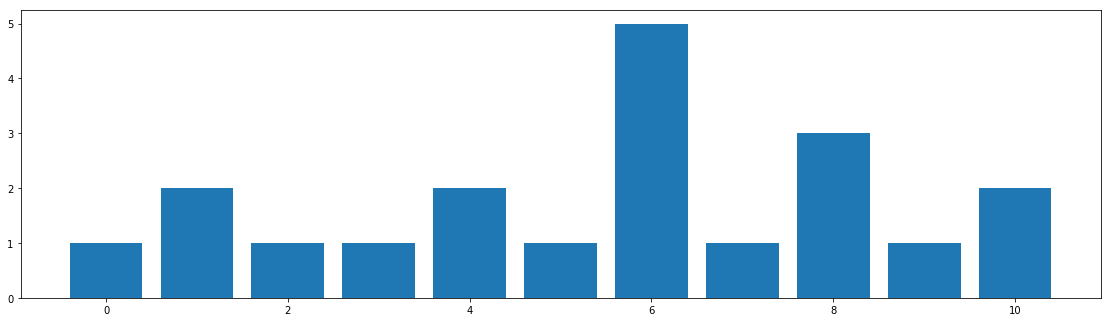

[array([20,  2]), array([30,  1]), array([30,  2]), array([40,  1]), array([50,  1]), array([60,  1]), array([70,  1]), array([80,  1]), array([90,  1]), array([90,  2]), array([100,   1])]
[1, 2, 1, 1, 2, 1, 5, 1, 3, 1, 2]


In [14]:
c= []
a=[]
for i in range (10,110,10):
    for j in range (1,11):
        a.append((i,j))

parameters = {'hidden_layer_sizes':a}
r = MLPRegressor(solver='lbfgs',tol=0.000001)
clf = GridSearchCV(r, parameters,scoring= 'neg_mean_squared_error', return_train_score= 'False')

for i in range(20):
    
    with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always")
            clf.fit(train['X'], train['Y'])
    c.append(clf.best_params_['hidden_layer_sizes'])
    print( 'ok')
    
print(c)
    
n = c
graph_comb(n)

In [ ]:
n[3]

(80, 7)
3.177
(100, 9)
3.018
(80, 8)
3.241
(80, 6)
3.161
(100, 9)
2.919
(90, 9)
3.135
(100, 9)
3.062
(80, 7)
3.081
(100, 5)
3.132
(80, 9)
3.17
(90, 9)
3.176
(100, 6)
3.165
(100, 5)
3.171
(100, 7)
3.2
(60, 8)
3.184
(90, 5)
3.196
(80, 5)
3.019
(100, 8)
2.97
(100, 9)
3.042
(100, 6)
3.199


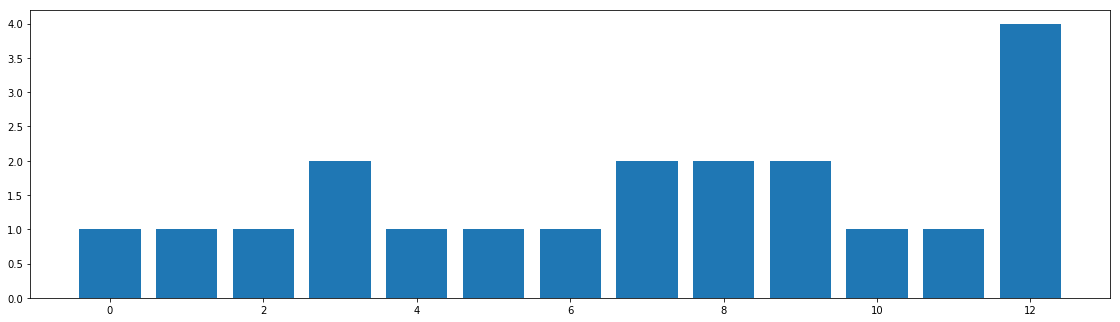

[array([60,  8]), array([80,  5]), array([80,  6]), array([80,  7]), array([80,  8]), array([80,  9]), array([90,  5]), array([90,  9]), array([100,   5]), array([100,   6]), array([100,   7]), array([100,   8]), array([100,   9])]
[1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 4]


In [48]:
c= []
conf = np.array([])
rep = np.array([])
for k in range(20):
    menor = 1000
    m=""
    error=10000
    for i in range (10,110,10):
        for j in range (1,10):

            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always") 
                rg = MLPRegressor(hidden_layer_sizes=(i,j), max_iter= 200, activation="relu",shuffle= False, solver= "adam",tol=0.000001)
                rg.fit(train["X"],train["Y"])

            if w==[]:
                error = errores(train["Y"],rg.predict(train["X"]))["RMS"]
                #print(str(i)+ ","+str(j)+" :" + str(error))

            if error<menor:
                menor = error
                m = (i,j)
    c.append(m)
    print(m)
    print(error)

n2 = c
graph_comb(n2)

(60, 8)
2.816
(90, 6)
0.899
(70, 8)
0.913
(100, 9)
0.755
(80, 8)
0.872
(80, 9)
3.125
(90, 8)
0.891
(90, 7)
0.91
(50, 9)
0.901
(80, 9)
0.871
(40, 8)
0.889
(50, 9)
0.881
(100, 8)
0.896
(60, 6)
0.881
(90, 9)
0.931
(90, 9)
0.895
(50, 8)
0.898
(90, 8)
0.865
(90, 6)
3.105
(70, 6)
3.144


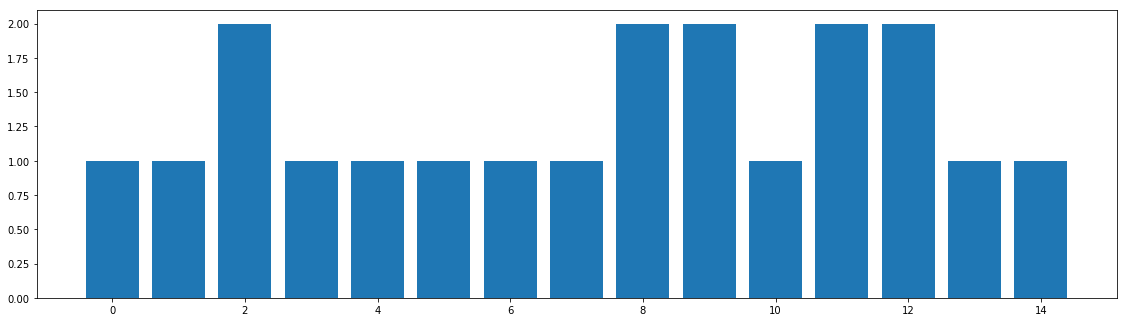

[array([40,  8]), array([50,  8]), array([50,  9]), array([60,  6]), array([60,  8]), array([70,  6]), array([70,  8]), array([80,  8]), array([80,  9]), array([90,  6]), array([90,  7]), array([90,  8]), array([90,  9]), array([100,   8]), array([100,   9])]
[1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1]


In [47]:
c= []
conf = np.array([])
rep = np.array([])
for k in range(20):
    menor = 1000
    m=""
    error =2000
    for i in range (10,110,10):
        for j in range (1,10):

            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always") 
                rg = MLPRegressor(hidden_layer_sizes=(i,j), max_iter= 200, activation="relu",shuffle= False, solver= "lbfgs",tol=0.000001)
                rg.fit(train["X"],train["Y"])

            if w==[]:
                error = errores(train["Y"],rg.predict(train["X"]))["RMS"]
                #print(str(i)+ ","+str(j)+" :" + str(error))

            if error<menor:
                menor = error
                m = (i,j)
    c.append(m)
    print(m)
    print(error)

n2 = c
graph_comb(n2)

In [ ]:
x = np.arange(1,len(conf)+1)
plt.bar(x,rep,tick_label=conf)
plt.plot()
plt.subplots_adjust(left=0.5, bottom=1, right=3, top=2)
plt.show()

In [ ]:
## 70,5; 100,4 ha demostrado se robusto

100,4: 0.875152938321

80,5: 0.906159720869
40,2: 0.87019985029

40,5: 0.92095431876

10,8: 0.902660282298





10,9: 0.912546525051

10,10: 0.898967559595

10,10: 0.912162930144

100,5: 0.894026533104

40,5: 0.896936773488


In [ ]:
n = np.array([(10,8),(10,3),(10,8),(10,5),(10,9),(10,6),(10,7),(30,5),(10,10),(20,5)])
graph_comb(n)